数据加载完成，共 1641 条记录。
类别分布：
Label
Vascular Dementia          350
Alzheimer's Disease        339
Parkinson's Disease        338
Lewy Body Dementia         319
Frontotemporal Dementia    295
Name: count, dtype: int64

词汇表大小: 9031

--- 10-Fold Cross-Validation Results ---
平均准确率: 0.6990 (+/- 0.0642)

--- Test Set Evaluation ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.68      0.57      0.62        68
Frontotemporal Dementia       0.80      0.75      0.77        59
     Lewy Body Dementia       0.60      0.66      0.63        64
    Parkinson's Disease       0.69      0.60      0.65        68
      Vascular Dementia       0.62      0.79      0.70        70

               accuracy                           0.67       329
              macro avg       0.68      0.67      0.67       329
           weighted avg       0.68      0.67      0.67       329



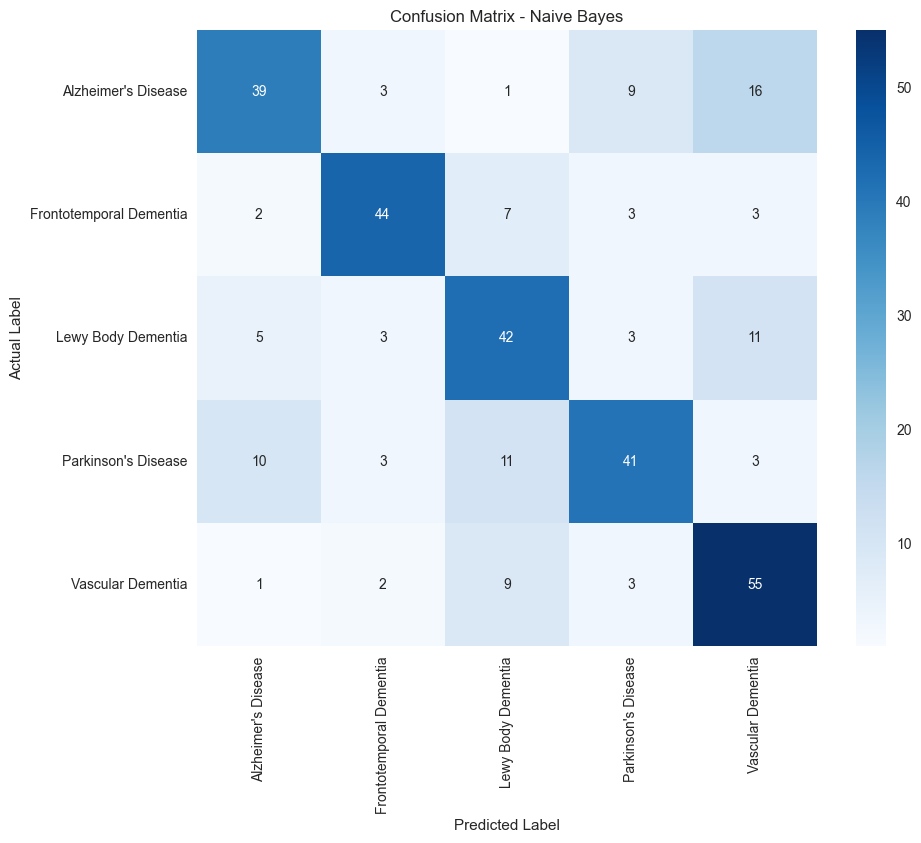

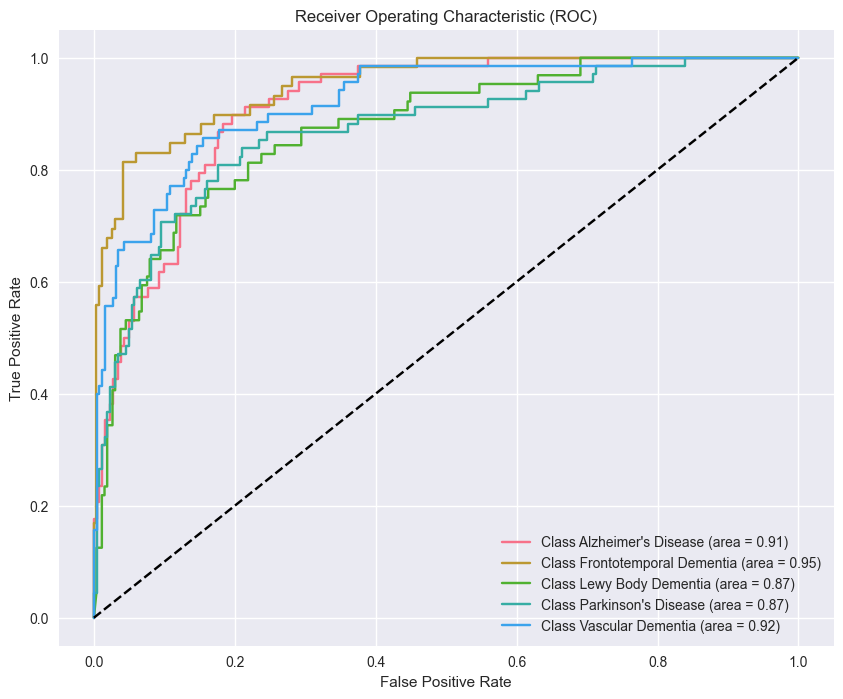

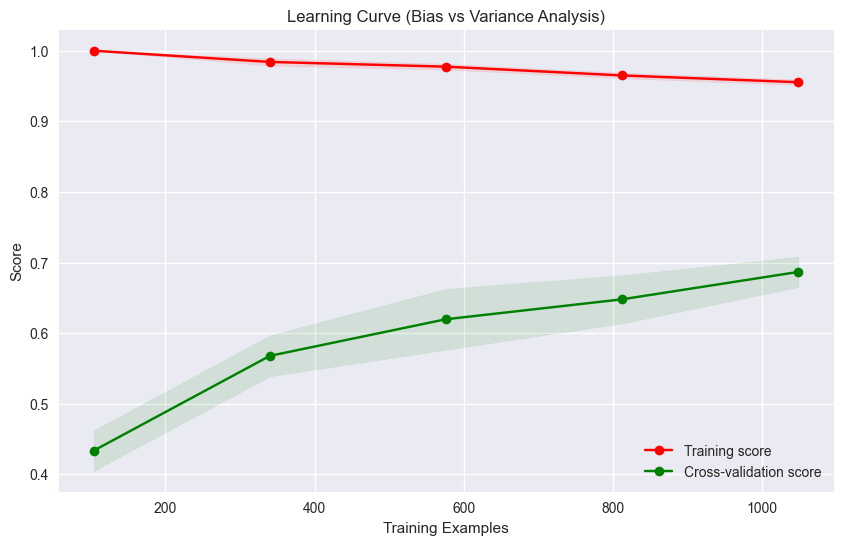


--- Error Analysis (Sample Misclassifications) ---
共发现 108 个错误分类样本。以下是前 3 个：
               True_Label            Predicted  \
99    Alzheimer's Disease    Vascular Dementia   
1056  Parkinson's Disease  Alzheimer's Disease   
1241  Parkinson's Disease    Vascular Dementia   

                                                   Text  
99    objective increasing focus [DISEASE] [DISEASE]...  
1056  post covid condition represent medical challen...  
1241  system online embase excerpta medica database ...  

--- Explainability: Top Keywords per Class ---
[Alzheimer's Disease]: ['amyloid', 'result', 'cell', 'inf', 'brain', 'cognitive', 'model', 'study', 'tau', 'disease']
[Frontotemporal Dementia]: ['ftld', 'group', 'variant', 'protein', 'al', 'mutation', 'tau', 'study', 'patient', 'disease']
[Lewy Body Dementia]: ['age', 'clinical', 'diagnosis', 'synuclein', 'brain', 'study', 'cognitive', 'body', 'patient', 'disease']
[Parkinson's Disease]: ['brain', 'result', 'method', 'analysis', 'using

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# 设置绘图风格
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ==========================================
# 1. 数据加载与准备
# ==========================================
# 读取CSV文件
df = pd.read_csv('cleaned_data.csv')

# 确保文本内容没有空值
df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

print(f"数据加载完成，共 {len(df)} 条记录。")
print("类别分布：")
print(df['Label'].value_counts())

# ==========================================
# 2. 特征工程 (Bag of Words) & 数据切分
# ==========================================
# 划分训练集和测试集 (80% 训练, 20% 测试)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label'], test_size=0.2, random_state=42, stratify=df['Label']
)

# 使用 CountVectorizer (BoW 特征)
# 这里使用 unigram (1,1)，如果需要更复杂的特征可以改为 (1,2)
vectorizer = CountVectorizer(ngram_range=(1, 1))
X_train_bow = vectorizer.fit_transform(X_train_raw)
X_test_bow = vectorizer.transform(X_test_raw)

print(f"\n词汇表大小: {len(vectorizer.get_feature_names_out())}")

# ==========================================
# 3. 模型训练 (Naïve Bayes) & 10折交叉验证
# ==========================================
nb_classifier = MultinomialNB()

# 执行 10-Fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(nb_classifier, X_train_bow, y_train, cv=cv, scoring='accuracy')

print("\n--- 10-Fold Cross-Validation Results ---")
print(f"平均准确率: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# 在全量训练集上训练模型
nb_classifier.fit(X_train_bow, y_train)

# ==========================================
# 4. 评估与可视化 (Evaluation & Viz)
# ==========================================
y_pred = nb_classifier.predict(X_test_bow)

print("\n--- Test Set Evaluation ---")
print(classification_report(y_test, y_pred))

# [图表 1] 混淆矩阵 (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - Naive Bayes')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# [图表 2] ROC 曲线 (多分类处理)
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_score = nb_classifier.predict_proba(X_test_bow)

plt.figure(figsize=(10, 8))
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {lb.classes_[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# ==========================================
# 5. 偏差与方差分析 (Bias & Variability) - 学习曲线
# ==========================================
train_sizes, train_scores, test_scores = learning_curve(
    MultinomialNB(), X_train_bow, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (Bias vs Variance Analysis)")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid(True)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

# ==========================================
# 6. 错误分析 (Error Analysis)
# ==========================================
print("\n--- Error Analysis (Sample Misclassifications) ---")
results = pd.DataFrame({'Text': X_test_raw, 'True_Label': y_test, 'Predicted': y_pred})
errors = results[results['True_Label'] != results['Predicted']]

if not errors.empty:
    print(f"共发现 {len(errors)} 个错误分类样本。以下是前 3 个：")
    print(errors.head(3)[['True_Label', 'Predicted', 'Text']])

    # 获取最具辨识度的关键词 (Explainability)
    print("\n--- Explainability: Top Keywords per Class ---")
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(nb_classifier.classes_):
        top10_indices = np.argsort(nb_classifier.feature_log_prob_[i])[-10:]
        top10_words = [feature_names[j] for j in top10_indices]
        print(f"[{class_label}]: {top10_words}")

# ==========================================
# 7. Massage the Data (Control Hardship)
# 通过截断文本长度来降低准确率，模拟增加预测难度
# ==========================================
print("\n--- Massage Data Experiment (Truncation) ---")
def massage_data_trunc(text, max_words=20):
    words = text.split()
    return ' '.join(words[:max_words])

# 创建截断后的数据集 (每篇文档仅保留前 20 个词)
df['Massaged_Content'] = df['Cleaned_Content'].apply(lambda x: massage_data_trunc(x, max_words=20))

# 重新训练和评估
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    df['Massaged_Content'], df['Label'], test_size=0.2, random_state=42, stratify=df['Label']
)
vec_m = CountVectorizer()
X_train_m_bow = vec_m.fit_transform(X_train_m)
X_test_m_bow = vec_m.transform(X_test_m)

nb_m = MultinomialNB()
nb_m.fit(X_train_m_bow, y_train_m)
acc_m = accuracy_score(y_test_m, nb_m.predict(X_test_m_bow))
print(f"原始准确率: {accuracy_score(y_test, y_pred):.4f}")
print(f"截断数据后准确率 (20 words): {acc_m:.4f}")
print("结论: 通过大幅减少可用特征(单词)，成功增加了模型的预测难度。")